# Track Features

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [174]:
df_features = pd.read_csv("./processed/ole/tracks_features.csv").rename({"spotify_track_uri": "track_uri"}, axis=1)
df_history_og = pd.read_csv("./processed/ole/history.csv").drop(["Unnamed: 0", "username", "platform", "ip_addr_decrypted", "user_agent_decrypted", "master_metadata_album_artist_name", "master_metadata_album_album_name", "episode_name", "episode_show_name", "spotify_episode_uri", "offline", "offline_timestamp", "incognito_mode"], axis=1).rename({"spotify_track_uri":"track_uri"}, axis=1)
df_history_og["ts"] = pd.to_datetime(df_history_og["ts"])
df_features.head(3)

,Unnamed: 0,master_metadata_track_name,master_metadata_album_album_name,track_uri,master_metadata_album_artist_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0,Grillz,"Hallo, wie geht's?",spotify:track:0035iPN5qiT9IKCUwcEH4e,Juicy Süß,0.10900,0.729,218187.0,0.435,0.000285,5.0,0.0678,-10.946,1.0,0.1540,109.922,4.0,0.716
1,1,Holland - Instrumental,Mikrokosmos,spotify:track:003XcXyeafgas0fF3BqxdS,257ers,0.03540,0.805,188613.0,0.811,0.894000,11.0,0.1510,-6.449,0.0,0.0573,120.984,4.0,0.542
2,2,Mr. Brightside,Hot Fuss,spotify:track:003vvx7Niy0yvhvHt4a68B,The Killers,0.00121,0.352,222973.0,0.911,0.000000,1.0,0.0995,-5.230,1.0,0.0747,148.033,4.0,0.236


## 1. Correlation Matrix

<Axes: >

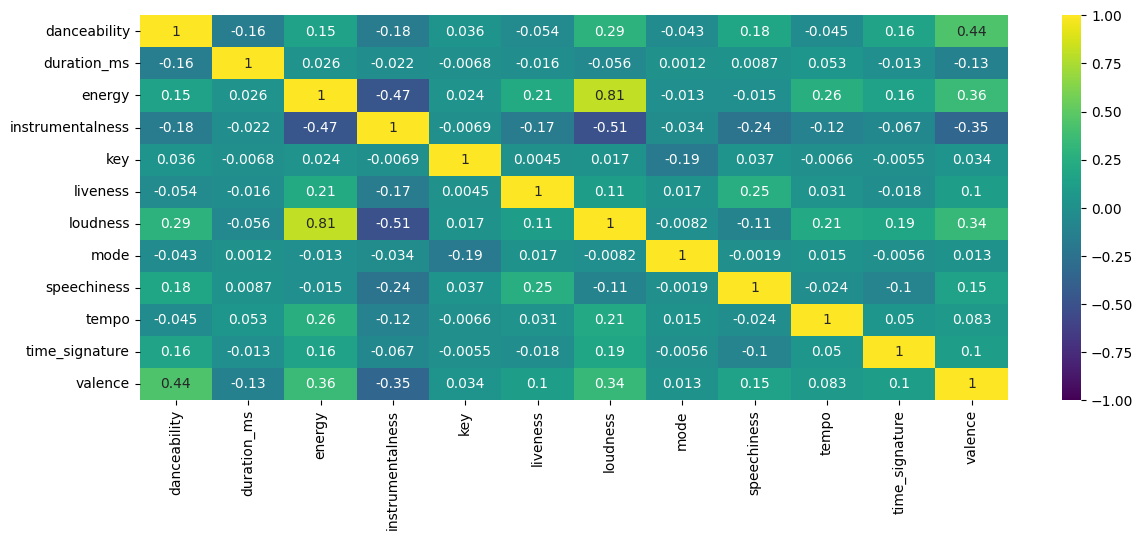

In [155]:
df_features_corr = df_features.set_index("track_uri").iloc[:,5:]
plt.figure(figsize=(14, 5))
sns.heatmap(df_features_corr.corr(), vmin=-1, vmax=1, annot=True, cmap="viridis")

### Correlation with Month of year

In [186]:
df_features_temp = df_features.set_index("track_uri").iloc[:, 4:].reset_index()
df_history_f = df_history_og[["ts", "track_uri"]].merge(df_features_temp, on="track_uri")
df_history_f_month = df_history_f.copy().drop("track_uri", axis=1)
df_history_f_month["month"] = df_history_f["ts"].map(lambda x: x.month)
df_history_f_month.head(3)

,ts,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,month
0,2022-09-30 07:27:34+00:00,0.0699,0.817,147252.0,0.674,0.006390,3.0,0.120,-7.787,0.0,0.0476,119.999,4.0,0.790,9
1,2022-09-30 07:31:17+00:00,0.2350,0.732,223778.0,0.785,0.000010,6.0,0.548,-3.430,1.0,0.0713,100.029,4.0,0.631,9
2,2022-09-30 07:38:50+00:00,0.7040,0.596,412964.0,0.380,0.000026,6.0,0.173,-9.316,0.0,0.0280,133.065,4.0,0.209,9


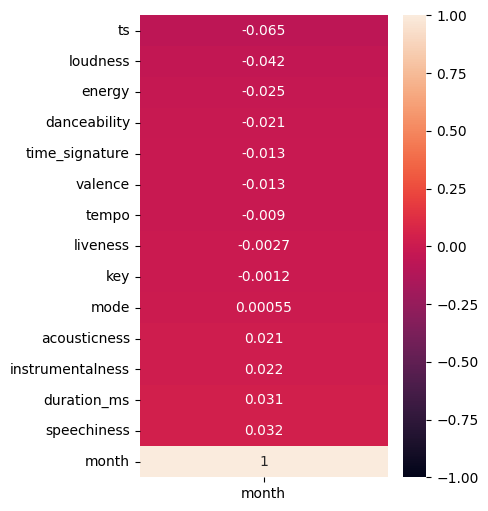

In [177]:
plt.figure(figsize=(4, 6))

heatmap = sns.heatmap(df_history_f_month.corr()[["month"]].sort_values(by="month"), vmin=-1, vmax=1, annot=True)

### Correlation Sunhours - Features

In [178]:
df_sun = pd.read_html("https://www.dwd.de/DE/leistungen/klimadatendeutschland/mittelwerte/sonne_9120_SV_html.html;jsessionid=27E6D24E6A659DD00B09487FC9252B0A.live31084?view=nasPublication&nn=16102")[1]

In [179]:
df_sun_month = df_sun[df_sun["Name der Station"] == "ROSTOCK-WARNEMUENDE"].iloc[:, 7:-1]

eng_months = pd.DataFrame([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], columns=["month"])
df_sun_month = df_sun_month.unstack().to_frame().reset_index().drop("level_1", axis=1).rename({"level_0": "month", 0: "sunhours"}, axis=1)
df_sun_month["month"] = eng_months["month"]
pprint(df_sun_month.head(3))
df_history_f_month = df_history_f_month.merge(df_sun_month, on="month", how="left")
df_history_f_month.head(3)

   month  sunhours
0      1       492
1      2       677
2      3      1333


,ts,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,month,sunhours
0,2022-09-30 07:27:34+00:00,0.0699,0.817,147252.0,0.674,0.006390,3.0,0.120,-7.787,0.0,0.0476,119.999,4.0,0.790,9,1687
1,2022-09-30 07:31:17+00:00,0.2350,0.732,223778.0,0.785,0.000010,6.0,0.548,-3.430,1.0,0.0713,100.029,4.0,0.631,9,1687
2,2022-09-30 07:38:50+00:00,0.7040,0.596,412964.0,0.380,0.000026,6.0,0.173,-9.316,0.0,0.0280,133.065,4.0,0.209,9,1687


### Correlation Hour of Day - Features

In [180]:
df_history_f_m_h = df_history_f_month
df_history_f_m_h["hour"] = df_history_f_m_h["ts"].map(lambda x:x.hour)
df_history_f_m_h.head(3)

,ts,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,month,sunhours,hour
0,2022-09-30 07:27:34+00:00,0.0699,0.817,147252.0,0.674,0.006390,3.0,0.120,-7.787,0.0,0.0476,119.999,4.0,0.790,9,1687,7
1,2022-09-30 07:31:17+00:00,0.2350,0.732,223778.0,0.785,0.000010,6.0,0.548,-3.430,1.0,0.0713,100.029,4.0,0.631,9,1687,7
2,2022-09-30 07:38:50+00:00,0.7040,0.596,412964.0,0.380,0.000026,6.0,0.173,-9.316,0.0,0.0280,133.065,4.0,0.209,9,1687,7


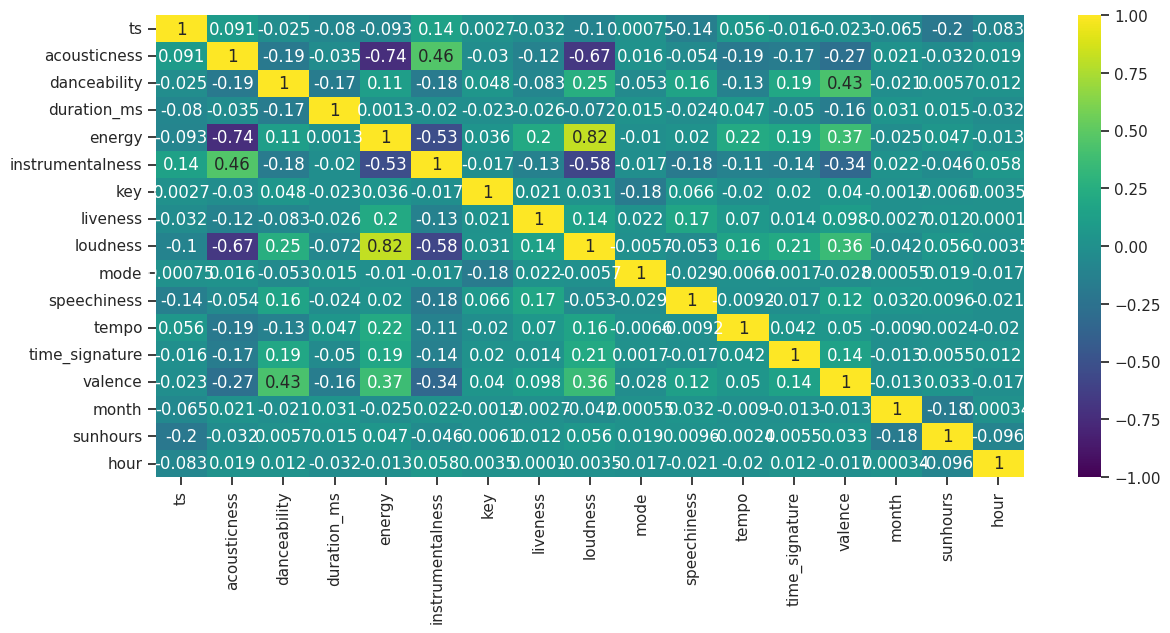

In [219]:
plt.figure(figsize=(14, 6))
sns.heatmap(df_history_f_m_h.corr(), vmin=-1, vmax=1, annot=True, cmap="viridis")
plt.savefig("./corr_matrix.png")

## TEST! (fix)

In [221]:
import scipy.stats as stats
import pylab

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16), constrained_layout=True)
df_data = df_history_f_m_h.drop("ts", axis=1)
#for i, col in enumerate(df_history_f_m_h.drop("ts", axis=1)):
#    sns.histplot(df_history_f_m_h[col], ax=ax.flatten()[i])
#    ax.flatten()[i].set_title(col)
#plt.savefig("norm_test.png")

In [248]:
from scipy.stats import kruskal

In [270]:
data = []
df_test = df_data[["month", "sunhours", "hour"]]
df_to_test = df_data.drop(["month", "sunhours", "hour"], axis=1)

for col_t in df_test:
    row_data = [col_t]
    for col in df_to_test:
        row_data.append(kruskal(df_test[col_t], df_data[col]))
    data.append(row_data)

pd.DataFrame(data, columns=["var", *df_to_test.columns])

,var,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,month,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
1,sunhours,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"
2,hour,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)"


In [289]:
df_dance = df_history_f_m_h[["ts", "danceability"]]
df_dance.iloc[:, 0] = pd.to_datetime(df_dance["ts"])
df_dance["year"] = df_dance["ts"].dt.year
df_dance["month"] = df_dance["ts"].dt.month

df_dance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78786 entries, 0 to 78785
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   ts            78786 non-null  datetime64[ns, UTC]
 1   danceability  78775 non-null  float64            
 2   year          78786 non-null  int32              
 3   month         78786 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(2)
memory usage: 1.8 MB


/tmp/ipykernel_1382717/2018098563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dance["year"] = df_dance["ts"].dt.year
/tmp/ipykernel_1382717/2018098563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dance["month"] = df_dance["ts"].dt.month


In [290]:
pivot = pd.pivot_table(df_dance, values="danceability", index="month", columns="year", aggfunc="mean", margins=True, margins_name="Avg", fill_value="")

pivot

/tmp/ipykernel_1382717/1035376920.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = pd.pivot_table(df_dance, values="danceability", index="month", columns="year", aggfunc="mean", margins=True, margins_name="Avg", fill_value="")


year,2015,2016,2017,2018,2019,2020,2021,2022,2023,Avg
month,,,,,,,,,,
1,,0.703513,0.563687,0.561119,0.639494,0.660832,0.648603,0.62599,0.619593,0.629545
2,,,0.630209,0.679047,0.587207,0.586119,0.621194,0.648964,0.647813,0.626411
3,,,0.572777,0.506512,0.60279,0.657054,0.581911,0.646528,0.661997,0.597503
4,,,0.659876,0.661465,0.629636,0.629932,0.589712,0.625675,0.624665,0.62254
5,,0.685122,0.635593,0.621442,0.627157,0.646356,0.588455,0.637191,0.598092,0.630546
6,,0.653818,0.605069,0.600121,0.613163,0.598564,0.60024,0.604459,,0.612472
7,,0.614474,0.613569,0.643525,0.628673,0.60973,0.603188,0.605385,,0.613553
8,,0.632415,0.602584,0.626669,0.54726,0.6257,0.60323,0.630809,,0.606607
9,,0.65624,0.627797,0.652605,0.619489,0.578443,0.570291,0.661032,,0.62403
